In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import svds
import networkx as nx
from copy import deepcopy
from scipy import linalg
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt

## Codebase usage examples

## NEEDS FIXING

Below are some examples of how to use the codebase with different data types. 

In [2]:
# replace with own path to data folder:
# path = 'path_to_data_folder'
# path = '/home/ag16115/Documents/phd/codebase_data/brazil'

Import all the functions:

In [3]:
from data_preparation.graph_functions import *
from data_preparation.time_series_functions import *
from data_preparation.text_analysis_functions import *
from embedding.embedding import *

# dynamic - lyon school 

In [4]:
# load data 
# need the activity_data.csv file
path = '/home/ag16115/Documents/phd/codebase_data/'
data = pd.read_csv(path + 'ia-primary-school-proximity-attr.edges', sep = ',', on_bad_lines='skip', header = None)
# data = pd.read_csv(path + '/activity_data.csv', sep = '\t', on_bad_lines='skip')

In [5]:
## rename columns   
data.columns = ['V1', 'V2', 'T', 'L1', 'L2']
## sort out time column
data['H'] = [int(int(t)/(60*60)) for t in list(data['T'])]
data['D'] = [int(int(t)/(60*60*24)) for t in list(data['T'])]
data['T1'] = [10*int(i/24) + i%24 - 8 for i in list(data['H'])]

In [6]:
def scree_plot(A, s = 1, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=50)
    SA = SA[::-1]

In [7]:
def scree_plot(A, k = 50, s = 10, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=k)
    fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(range(len(SA)), np.sort(SA)[::-1], s =s)
    if vline:
        plt.axvline(x=vline, color='green', linewidth=0.5)

In [8]:
A, attributes = matrix_from_tables(data, ['V1','V2'], dynamic_col='T', join_token='::')

['V1', 'V2']


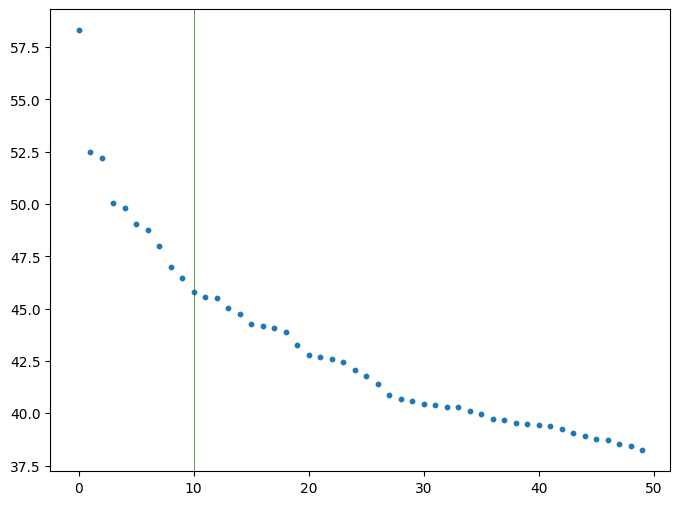

In [9]:
d = 10
scree_plot(A, k = 50,s = d, vline=10)

In [10]:
d = 10
embedding = embed(A, d = d, right_embedding=True)
LHS = embedding[0]  
RHS = embedding[1]  

LHS = degree_correction(LHS)      
RHS = degree_correction(RHS)  


/home/ag16115/Documents/phd/codebase/embedding/embedding.py:202: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn(


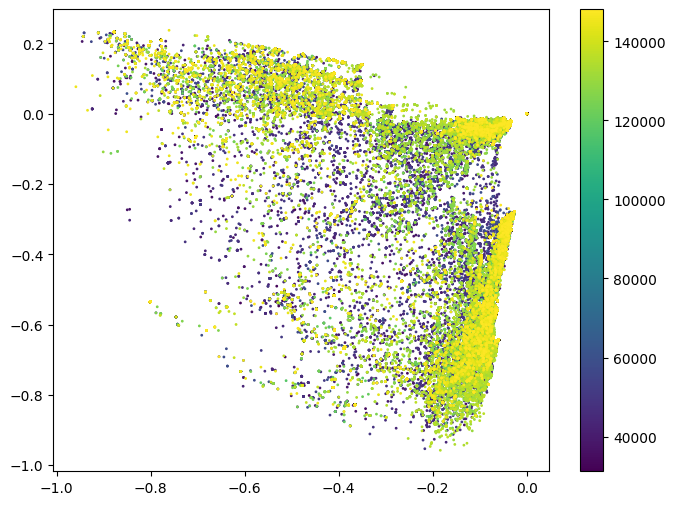

In [11]:
## plot the right hand side embedding and colour by time    
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')   
plt.scatter(RHS[:,0], RHS[:,1], c = [att['time'] for att in attributes[1]], s = 1, cmap = 'viridis')    
plt.colorbar()
plt.show()

# multipartite - brazil

The data contains information about the procurement process in Brazil. Each row contains information about a tender with information:
- Tender: tender id
- Period: time 
- Buyer: who is funding
- Item: what the tender is abour 
- Company: who has bid for the tender
- bidder_win: whether the bid was won or not

In [12]:
data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')
A, attributes = matrix_from_tables(data, [['Company', 'Tender'], ['Company', 'Buyer'],['Company', 'Item']],dynamic_col = 'Period', join_token='::')

/tmp/ipykernel_23584/558244675.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')


['Company', 'Tender']
['Company', 'Buyer']
['Company', 'Item']


In [13]:
# find subgraph wanted

subgraph_attributes = [
    [{'partition': 'Company'},{'partition': 'Tender'}],
    {'partition': 'Buyer'}
]

# subgraph_attributes = [
#     {'partition': 'Company'},
#     {'partition': 'Buyer'}
# ]
subgraph_A, subgraph_attributes  = find_subgraph(A, attributes,subgraph_attributes)

In [14]:
# A_dilation = symmetric_dilation(subgraph_A)
# is_symmetric(A_dilation)

In [15]:
# take the largest connected component
cc_A, cc_attributes = find_connected_components(A, attributes,n_components = 1)

Number of connected components: 217748


In [16]:
cc_A.shape

(21792, 392256)

In [17]:
d = 10
embedding = embed(A, d=d)

/home/ag16115/Documents/phd/codebase/embedding/embedding.py:202: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn(


# toy data

In [18]:
df = pd.DataFrame(
    {'A': ['a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a2', 'a2'],
        'B': ['b1', 'b2', 'b1', 'b2', 'b1', 'b2', 'b1', 'b2'],
        'ID': [1, 1, 1, 1, 2, 2, 2, 2]})
relationships = ['A', 'B']
time_col = 'ID'
A1, attributes1 = matrix_from_tables(
    df, relationships, dynamic_col=time_col, join_token='::')

c0, att0 = find_cc_containing_most(A1, attributes1, 'B', dynamic=False)
c1, att1 = find_cc_containing_most(A1, attributes1, 'A', dynamic=True)

['A', 'B']
Number of connected components: 2
Number of connected components: 2


# weighted - harry potter 

## needs to be incorporated

In [19]:
path = '/home/ag16115/Documents/phd/codebase_data'
data = pd.read_csv(path + '/harry_potter.csv', sep=',')
attributes = pd.read_csv(path + '/HP-characters.csv', sep=',')

In [20]:
## replace - in type column to -1 and + to 1    
data['type'] = [1 if t == '+' else -1 for t in list(data['type'])]

In [21]:
A, attributes = matrix_from_tables(data, ['source','target'], weight_col=None)

['source', 'target']


# time series

In [22]:
data = pd.read_csv(path + '/sp500_data.csv', sep=',')

In [23]:
def matrix_from_time_series(data, time_col, drop_nas = True):
    data = data.sort_values(by=time_col)
    data = data.dropna(axis=1, how='any')

    times = list(data[time_col])
    data.drop([time_col], axis=1, inplace=True)
    ids = list(data.columns)

    Y = np.array(data).T
    attributes = [
        [{'name': i} for i in ids], [{'time': i} for i in times]
    ]
    return Y, attributes

In [24]:
Y, attributes = matrix_from_time_series(data, 'date')

In [25]:
Y.shape

(468, 1259)

In [26]:
(n,p) = Y.shape

# text analysis

In [27]:

from textblob import Word
from nltk.corpus import stopwords
import nltk
import re
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ag16115/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
# def pc_scores(X, r):
#     U, s, Vh = svds(X, k=r)
#     idx = s.argsort()[::-1]
#     Vh = Vh[idx, :]
#     Y = X @ Vh.T
#     return Y

In [29]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()  # remove=('headers', 'footers', 'quotes')
# # pprint(list(newsgroups.target_names))

# create dataframe from newsgroup data
df = pd.DataFrame()
df["data"] = newsgroups["data"]

In [34]:
Y,attributes = matrix_from_text(df, 'data', remove_stopwords=True, clean_text = True, 
                     remove_email_addresses = True, update_stopwords = ['subject'],
                     min_df = 5, max_df = len(df)-1000)

In [35]:
for i in range(len(attributes[1])):
    attributes[1][i].update(
        {'label': newsgroups["target_names"][newsgroups["target"][i]]})

In [36]:
df1 = pd.DataFrame(
    ['This is a test sentence', 'This is another test sentence', 'This contains an email address: email_address@email.com'], columns=['data'])

Y1, attributes1 = matrix_from_text(df1, 'data', remove_email_addresses=True)